# Self Driving Car Project 3 Behavioral Cloning

In [1]:
# import packages
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D

import pandas as pd
import cv2
import numpy as np


from keras.layers.core import Lambda
from keras.utils import np_utils
from keras.preprocessing import image
from keras.optimizers import Adam
from keras import backend as K
from keras.applications import VGG16

from matplotlib import pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
%matplotlib inline

Using TensorFlow backend.


## Data exploration

In [2]:
data_dir = 'data/'
sim_data = pd.read_csv(data_dir+'driving_log.csv')
sim_data.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [3]:
sim_data.describe()

,steering,throttle,brake,speed
count,8036.000000,8036.000000,8036.000000,8036.000000
mean,0.004070,0.869660,0.001970,28.169839
std,0.128840,0.301326,0.036565,6.149327
min,-0.942695,0.000000,0.000000,0.502490
25%,0.000000,0.985533,0.000000,30.183093
50%,0.000000,0.985533,0.000000,30.186400
75%,0.000000,0.985533,0.000000,30.186640
max,1.000000,0.985533,1.000000,30.709360


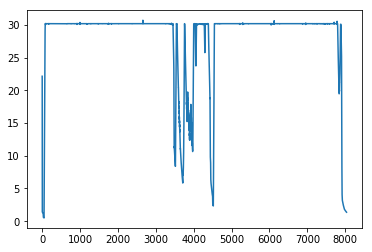

In [4]:
plt.plot(sim_data['speed'])

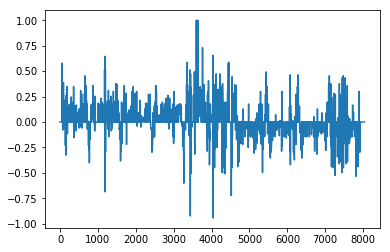

In [5]:
plt.plot(sim_data['steering'])

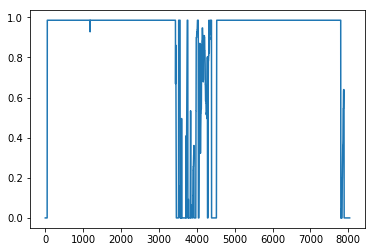

In [6]:
plt.plot(sim_data['throttle']) 

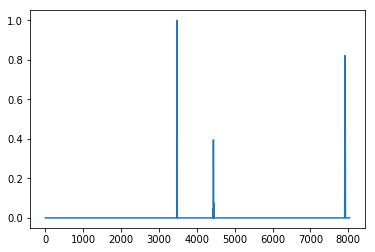

In [7]:
plt.plot(sim_data['brake'])

We find that 
There is a lot of variation in the steering angles. 
The speed, brake, and throttle remain fairly constant.

## Image Explorations

In [8]:
no_turn = sim_data[sim_data['steering'] == 0.0 ].iloc[0]
left_turn = sim_data[(sim_data['steering'] >= 0.6) & (sim_data['steering'] <= 1.0) ].iloc[0]
right_turn = sim_data[(sim_data['steering'] >= -1) & (sim_data['steering'] <= -0.6) ].iloc[0]

In [9]:
def plot_images_from_row(row, image_preprocess=lambda x: x):
    f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 5))
    image = plt.imread(data_dir+ row['left'].strip())
    ax1.imshow(image_preprocess(image))
    ax1.grid(False)
    
    image = plt.imread(data_dir+ row['center'])
    ax2.imshow(image_preprocess(image))
    ax2.grid(False)
    image = plt.imread(data_dir+ row['right'].strip())
    ax3.imshow(image_preprocess(image))
    ax3.grid(False)

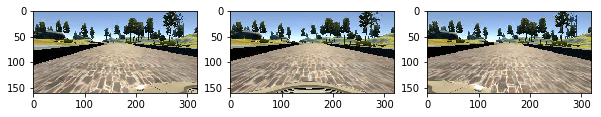

In [10]:
plot_images_from_row(no_turn)

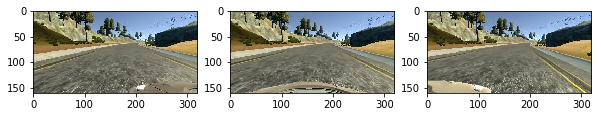

In [11]:
plot_images_from_row(left_turn)

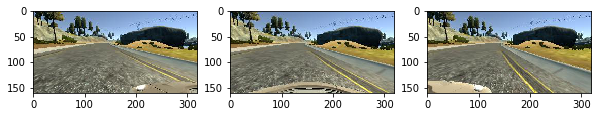

In [12]:
plot_images_from_row(right_turn)

from the initial observation of the images we see that the bottom part of the images contain the image of the car, i chose to crop the image so that the images can be used for data augmentation to create recovery scenarios for the car

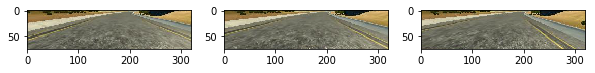

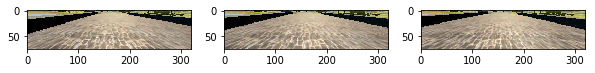

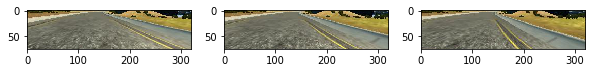

In [13]:
def crop_image(image, top=60, bottom=135):
    return image[top:bottom]

plot_images_from_row(left_turn, crop_image)
plot_images_from_row(no_turn, crop_image)
plot_images_from_row(right_turn, crop_image)

Let's also observe the images in different color spaces to see if a different representation helps segment the features more obvious

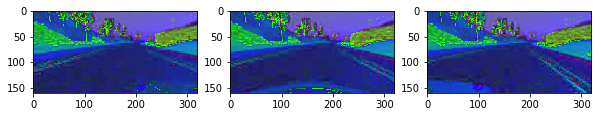

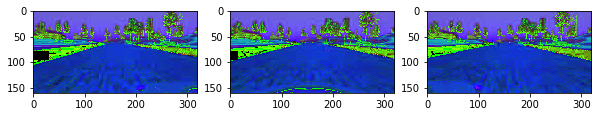

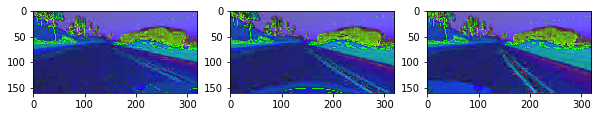

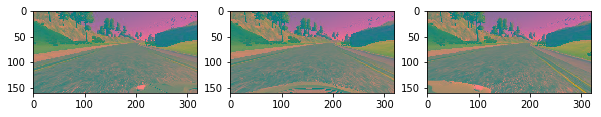

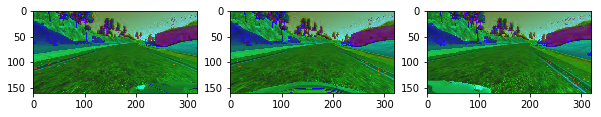

In [14]:
def convert_to_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
plot_images_from_row(left_turn, convert_to_hsv)
plot_images_from_row(no_turn, convert_to_hsv)
plot_images_from_row(right_turn, convert_to_hsv)
def convert_to_yuv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
plot_images_from_row(left_turn, convert_to_yuv)

def convert_to_hls(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
plot_images_from_row(left_turn, convert_to_hls)

## Data Augmentation
The ideas explored include :
The data from left and right cameras are used by turning angle adjustments;
Translations on y axis to represent uphill and downhill movement;
Brightness adjustment;



In [15]:
def preprocess_function(image):
    return cv2.resize(crop_image(image),(224, 49), interpolation= cv2.INTER_AREA)

def load_image(src, preprocess_function=preprocess_function):
    image = plt.imread(src)
    return preprocess_function(image)

all_images = []
for img_src in tqdm(sim_data['center']):
    all_images.append(load_image(data_dir+img_src.strip()))

for img_src in tqdm(sim_data['left']):
    all_images.append(load_image(data_dir+img_src.strip()))

for img_src in tqdm(sim_data['right']):
    all_images.append(load_image(data_dir+img_src.strip()))


100%|██████████| 8036/8036 [00:18<00:00, 433.66it/s]


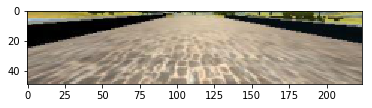

In [16]:
plt.imshow(all_images[0])

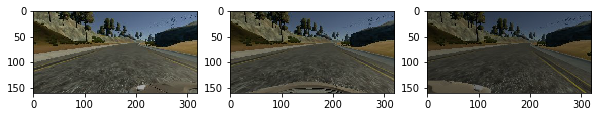

In [17]:
def augment_brightness(image):
    change_pct = np.random.uniform(0.4, 1.2)
    
    # Change to HSV to change the brightness V
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[:,:,2] = hsv[:,:,2] * change_pct
    
    #Convert back to RGB 
    img_brightness = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return img_brightness

plot_images_from_row(left_turn, augment_brightness)

In [18]:
all_images = np.asarray(all_images)
brightness_augmented = np.asarray([augment_brightness(image) for image in all_images])
all_images = np.append(all_images,brightness_augmented, axis=0)
all_images = np.append(all_images,all_images[:,:,::-1],axis=0)

In [19]:
steering_angles = sim_data['steering']
steering_left = steering_angles.copy().apply(lambda x: min(1,x+0.3))
steering_right = steering_angles.copy().apply(lambda x: max(-1,x-0.3))
steering_angles = steering_angles.append(steering_left)
steering_angles = steering_angles.append(steering_right)


In [20]:
steering_angles = np.asarray(steering_angles)
# for brightness augmentation
steering_angles = np.append(steering_angles,steering_angles,axis=0)

# for flipping
steering_angles = np.append(steering_angles,-steering_angles,axis=0)

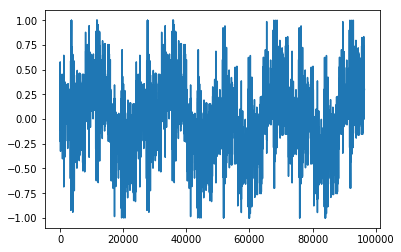

In [21]:
plt.plot(steering_angles)

In [22]:
all_images.shape

(96432, 49, 224, 3)

Split the augmented dataset into the training and validation sets,

In [ ]:
X_train, X_test, y_train , y_test = train_test_split(all_images, steering_angles, test_size=0.1)

In [ ]:
"""
print(X_train.shape)
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
"""

In [ ]:
train_datagen = image.ImageDataGenerator()
test_datagen = image.ImageDataGenerator()

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

## Nvidia End to End Learning and VGG models transfer learning
Nvidia End to End Learning for Self-Driving Cars https://arxiv.org/abs/1604.07316. 

#### 1. Nvidia End to End Learning model


In [ ]:
model_a = Sequential([
        Lambda(lambda x: (x/ 127.5 - 1.),input_shape=(49,224,3)),
        Convolution2D(3, 1,1, border_mode='same', activation='relu'),
        MaxPooling2D(),
        Dropout(0.1),
        Convolution2D(32, 5 , 5, border_mode='same', activation='relu'),
        MaxPooling2D(),
        Dropout(0.2),
        Convolution2D(64, 5 , 5, border_mode='same', activation='relu'),
        MaxPooling2D(),
        Dropout(0.2),
        Convolution2D(64, 3 , 3, border_mode='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dropout(0.3),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='tanh'),
        Dropout(0.2),
        Dense(1),
    ])
model_a.compile(optimizer=Adam(), loss='mse')
model_a.summary()

#### 2.  VGG16 feature transfer

In [ ]:
vgg_features = VGG16(include_top=False, input_shape=(49, 224, 3), weights='imagenet')
vgg_model = Sequential([
        Lambda(lambda x: (x/ 127.5 - 1.),input_shape=(49,224,3)),
    ])
for l in vgg_features.layers:
    l.trainable = False
vgg_model.add(vgg_features)

vgg_model.add(Flatten())
vgg_model.add(Dropout(0.2))
vgg_model.add(Dense(256, activation='relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(10, activation='tanh'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(1))
vgg_model.compile(loss='mse', optimizer=Adam())
vgg_model.summary()

#Evaluate on the mean square error metric

In [ ]:
batches = train_datagen.flow(X_train, y_train, batch_size=128)
test_batches = train_datagen.flow(X_test, y_test, batch_size=128)
model_a.fit_generator(batches, batches.n, nb_epoch=25, 
                      validation_data=test_batches, nb_val_samples=test_batches.n, 
                      verbose=1)

In [ ]:
### print the keys contained in the history object
print(model_a.history.keys())

### plot the training and validation loss for each epoch
plt.plot(model_a.history['loss'])
plt.plot(model_a.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [ ]:
batches = train_datagen.flow(X_train, y_train, batch_size=128)
test_batches = train_datagen.flow(X_test, y_test, batch_size=128)
vgg_model.fit_generator(batches, batches.N, nb_epoch=10, 
                        validation_data=test_batches, 
                        nb_val_samples=test_batches.N, verbose=1)

In [ ]:
### print the keys contained in the history object
print(vgg_model.history.keys())

### plot the training and validation loss for each epoch
plt.plot(vgg_model.history['loss'])
plt.plot(vgg_model.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

While the MSE metric was used to evaluate the model during training, I decided to visualize what the network predicts when given the the ordered dataset, this will help judge how stable the vehicle will drive on the track.

In [ ]:
ordered_track = []
for img_src in tqdm(simulation_data['center']):
    ordered_track.append(load_image(data_directory+img_src.strip()))

In [ ]:
ordered_track  = np.asarray(ordered_track)

In [ ]:
nvidia_model_predictions = model_a.predict(ordered_track, batch_size=128)

In [ ]:
plt.plot(nvidia_model_predictions)

In [ ]:
vgg_model_predictions = vgg_model.predict(ordered_track, batch_size=128)

In [ ]:
plt.plot(vgg_model_predictions)

Saving the models to the models/unregularized directory

In [ ]:
%mkdir "models"
%mkdir "models/unregularized"


In [ ]:
unregularized_dir = "models/unregularized/"

model_json = model_a.to_json()
with open(unregularized_dir+"nvidia_model.json", "w") as json_file:
    json_file.write(model_json)

model_a.save_weights(unregularized_dir+"nvidia_model.h5")
print("Saved model to disk")


In [ ]:
unregularized_dir = "models/unregularized/"
model_json = vgg_model.to_json()
with open(unregularized_dir+"vgg_model.json", "w") as json_file:
    json_file.write(model_json)

vgg_model.save_weights(unregularized_dir+"vgg_model.h5")
print("Saved model to disk")